In [1]:
# Jupyter notebook for analyzing DOGAMI data, see Scott Tse's emergence-response notebook at
# https://github.com/hackoregon/emergency-response/blob/analytics/notebooks/census_eda_geo.ipynb
# NOTE: Don't need all of these!
# Import modules included in "kitchen-sink"
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import gdal
import pandas as pd
import psycopg2
import seaborn as sns
import sys
# Import modules NOT included in "kitchen-sink", not sure about osgeo...
from dotenv import load_dotenv, find_dotenv
import geoplot as gplt
from osgeo import osr, ogr 
import rasterio
from rasterstats import point_query, zonal_stats

%matplotlib inline

F.D. Pearce, 04/16/18

Notebook for computing statistics on raster pixel values contained within a geometry (shape) file

In [2]:
# Functions for interacting with PostGres database
def pgconnect():
    """Establish connection to PostGres database using the parameters specified in .env file.
    First, walk root diretory to find and load .env file w/ PostGres variables defining database, 
    user, host, password, and port variables.
    Then, return connection to database from psycopg2.connect
    """
    try:
        load_dotenv(find_dotenv())
        conn = psycopg2.connect(database=os.environ.get("PG_DATABASE"), user=os.environ.get("PG_USER"), 
                            password = os.environ.get("PG_PASSWORD"), 
                            host=os.environ.get("PG_HOST"), port=os.environ.get("PG_PORT"))
        print("Opened database successfully\n")
        return conn
    except psycopg2.Error as e:
        print("I am unable to connect to the database\n")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None
    
def gpd_query(QUERY, geom_col=False):
    '''
    This function takes an SQL query, connects to postgres, 
    and returns either 1) a pandas dataframe, if geom_col is not a string, or
    a geodataframe that also contains a column named geom_col with shape data, 
    typically geom_col='geom'
    NOTE: this combines the functionality of pd_query and gpd_query
    originally written by Scott Tse for emergency response (see link above)
    '''
    conn = pgconnect()
    cur = conn.cursor()
    print("SQL QUERY = "+QUERY+'\r\n')
    try:
        if not isinstance(geom_col, str):
            # Return pandas dataframe, including column names from database
            cur.execute("SET statement_timeout = 0")
            cur.execute(QUERY)
            col_names = [cn[0] for cn in cur.description]
            #for elt in cur.description:
            #col_names.append(elt[0])    
            df = pd.DataFrame(cur.fetchall(), columns=col_names)
            print("Created pandas dataframe!")
            return df
        else:
            geo_df = gpd.GeoDataFrame.from_postgis(QUERY, 
            conn, geom_col=geom_col, crs={'init': u'epsg:4326'}, 
            coerce_float=False)
            print("Created geopandas dataframe using geom_col={}!".format(geom_col))
            return geo_df
    except Exception as e:
        print(e)
    finally:
        conn.close()

In [3]:
# Take a look at each table
# get all rows from loss by neighborhood unit table
QUERY1='''SELECT *
FROM loss_neighborhood_unit_csz_m9p0_dry;
'''
df1 = gpd_query(QUERY1)
df1.info()

# get all rows from loss by neighborhood unit table
QUERY_nu ='''SELECT *
FROM neighborhood_units;
'''
df_nu = gpd_query(QUERY_nu, "wkb_geometry")
#print(df_nu.crs)
df_nu.info()

# get all rows from loss by neighborhood unit table
QUERY_ju ='''SELECT *
FROM jurisdictions;
'''
df_ju = gpd_query(QUERY_ju, "wkb_geometry")
#print(df_ju.crs)
df_ju.info()

Opened database successfully

SQL QUERY = SELECT *
FROM loss_neighborhood_unit_csz_m9p0_dry;


Created pandas dataframe!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 22 columns):
objectid         876 non-null int64
nuid             876 non-null int64
bldgloss         876 non-null float64
bldg_lr          876 non-null float64
contentloss      876 non-null int64
debris           876 non-null int64
displacedpop     876 non-null float64
casdaytotal      876 non-null float64
casdayl1         876 non-null float64
casdayl2         876 non-null float64
casdayl3         876 non-null float64
casdayl4         876 non-null float64
casnighttotal    876 non-null float64
casnightl1       876 non-null float64
casnightl2       876 non-null float64
casnightl3       876 non-null float64
casnightl4       876 non-null float64
pdsnone          876 non-null int64
pdsslight        876 non-null int64
pdsmoderate      876 non-null int64
pdsextensive     876 non-nul

In [4]:
# Define functions for manipulating geoshapes and raster files
def get_gdfcrs_epsg(gdf):
    """Return integer EPSG code corresponding to Coordinate Reference
    used in input geodataframe, gdf. Attribute gdf.crs must contain
    a dict with key = 'init' that contains a string starting with 'epsg',
    followed by a colon, followed by an integer as a string.
    """
    try:
        dfepsg = gdf.crs['init'].split(':')
        if dfepsg[0] == 'epsg':
            return int(dfepsg[1])
    except:
        print('Error accessing geodataframe crs as EPSG code')

# Was for debugging, not used currently!
def esriprj2standards(prj_txt):
   #prj_file = open(shapeprj_path, 'r')
   #prj_txt = prj_file.read()
   srs = osr.SpatialReference()
   srs.ImportFromESRI([prj_txt])
   print('Shape prj is: {}'.format(prj_txt))
   print('WKT is: {}'.format(srs.ExportToWkt()))
   print('Proj4 is: {}'.format(srs.ExportToProj4()))
   srs.AutoIdentifyEPSG()
   print('EPSG is: {}'.format(srs.GetAuthorityCode(None)))

#ds = gdal.Open("{}/{}.tif".format(rasterdir, tifname))
#prj_txt = ds.GetProjection()
#esriprj2standards(prj_txt)

def get_raster_info_srs(raster_file, print_info=True):
    """Print information about raster file, and return its
    spatial reference system using gdal.
    """
    if print_info:
        try:
            print(gdal.Info(raster_file))
        except:
            print("Can't read info from raster file = {}".format(raster_file))
    try:
        raster = gdal.Open(raster_file)
    except:
        print("Error opening raster file".format(raster_file))
    else:
        raster_srs = osr.SpatialReference()
        raster_srs.ImportFromWkt(raster.GetProjection())
        return raster_srs
    
def get_geopoints_gpdepsginp_to_srsout(geom, gdf, x_col, y_col, srs_out):
    """Return list of georeferenced geometries, either points or polygons,
    converted from an epsg-defined Spatial Reference (SRS) in the input 
    geodataframe, gdf.  X and Y values of the points are defined by the 
    x_col and y_col columns of gdf.  Points are then transformed to the
    input SRS, srs_out"""
    geom_out = {}
    # Define input spatial reference using epsg code from gdf
    srs_inp = ogr.osr.SpatialReference()
    srs_inp.ImportFromEPSG(get_gdfcrs_epsg(gdf))
    #print(point_srs)
    if geom == 'Point':
        geom_out[geom] = []
        # Define list of points in transformed spatial reference
        for x, y in zip(gdf[x_col], gdf[y_col]):
            point = ogr.Geometry(ogr.wkbPoint)
            point.AddPoint(x, y)
            point.AssignSpatialReference(srs_inp)
            # Convert point co-ordinates so that they are in same projection as raster 
            point.Transform(osr.CoordinateTransformation(srs_inp, srs_out))
            geom_out[geom].append(point.ExportToWkt())
    elif geom == 'Poly':
        geom_out[geom] = []
        # Define list of polygons in transformed spatial reference
        for g in gdf[x_col]:
            # Only one Polygon in each MultiPolygon
            poly = ogr.CreateGeometryFromWkt(g.geoms[0].wkt)
            poly.AssignSpatialReference(srs_inp)
            # Convert point co-ordinates so that they are in same projection as raster 
            poly.Transform(osr.CoordinateTransformation(srs_inp, srs_out))
            geom_out[geom].append(poly.ExportToWkt())
    else:
        print("Geometry, {}, not recognized".format(geom))
    return geom_out

In [5]:
# Compute statistics on raster file pixel values at a single point (point_query)
# or computed for all pixels contained within a specified geometry (e.g. polygon)
QUERY='''SELECT lc.bldgloss AS buildingloss, 
    lc.bldg_lr AS buildingloss_ratio,
    (lc.casdaytotal + casnighttotal)/2 AS casualities_avetotal,
    ST_TRANSFORM(nu.wkb_geometry, 4326) AS geometry,
    ST_X(ST_TRANSFORM(ST_Centroid(nu.wkb_geometry), 4326)) AS nucenter_lon,
    ST_Y(ST_TRANSFORM(ST_Centroid(nu.wkb_geometry), 4326)) AS nucenter_lat, 
    ST_ASText(ST_TRANSFORM(ST_Centroid(nu.wkb_geometry), 4326)) AS nucenter,
    nu.county AS county
FROM neighborhood_units nu
INNER JOIN loss_neighborhood_unit_csz_m9p0_dry lc
ON nu.objectid = lc.objectid
ORDER BY casualities_avetotal DESC
'''
raster_file = './CSZ_M9p0_pgv_site.tif'
#raster_file = './CSZ_M9p0_PGD_liquefaction_wet.tif'
geom_type = 'Poly'

# 1) Get geodataframe, gdf, from postgis db with columns from loss table
# joined with neighborhood unit table
gdf = gpd_query(QUERY, geom_col="geometry")
gdf.info()

# 2) Print info about tif file and get its spatial reference info
srs_raster = get_raster_info_srs(raster_file, print_info=False)

# 3) Generate a list of point values transformed from the srs used in the 
# input geodataframe, gdf, to the srs used in the raster file, srs_raster
# This is inefficient and not very general, better to do handle with postgis in db query,
# or just fix this up?
if geom_type == 'Point':
    geom_ras = get_geopoints_gpdepsginp_to_srsout( \
            geom_type, gdf, 'nucenter_lon', 'nucenter_lat', srs_raster
    )
elif geom_type == 'Poly':
    geom_ras = get_geopoints_gpdepsginp_to_srsout( \
            geom_type, gdf, 'geometry', None, srs_raster
    )
else:
    print("Unrecognized geometry type = {}".format(geom_type))

# 4) Use rasterstats to compute analytics on pixel values within specified geometry, 
# such as a point, polygon, etc., MUST be transformed to srs_raster!
# For example, return pixel values corresponding to raster_points, the centroid of 
# each neighborhood unit in the srs_raster coordinate system
# Finally, include computed point values, stats, etc. from pixel values into geodataframe
if "Point" in geom_ras:
    nucenter_pgv = point_query(geom_ras['Point'], raster_file, band=1)
    gdf['nucenter_pgv'] = pd.Series(nucenter_pgv, index=gdf.index)
    #print(nucenter_pgv)
elif "Poly" in geom_ras:
    # ToDo: Fix the zonal stats next, need to convert to raster spatial reference, srs_raster
    nustats_pgv = zonal_stats(geom_ras['Poly'], raster_file, band=1)
    gdf_pv = pd.DataFrame(nustats_pgv, index=gdf.index)
    gdf_pv.rename(columns={co: "nupv_"+co for co in gdf_pv.columns}, inplace=True)
    gdf_merge = pd.merge(gdf, gdf_pv, left_index=True, right_index=True)
    #print(nustats_pgv)

Opened database successfully

SQL QUERY = SELECT lc.bldgloss AS buildingloss, 
    lc.bldg_lr AS buildingloss_ratio,
    (lc.casdaytotal + casnighttotal)/2 AS casualities_avetotal,
    ST_TRANSFORM(nu.wkb_geometry, 4326) AS geometry,
    ST_X(ST_TRANSFORM(ST_Centroid(nu.wkb_geometry), 4326)) AS nucenter_lon,
    ST_Y(ST_TRANSFORM(ST_Centroid(nu.wkb_geometry), 4326)) AS nucenter_lat, 
    ST_ASText(ST_TRANSFORM(ST_Centroid(nu.wkb_geometry), 4326)) AS nucenter,
    nu.county AS county
FROM neighborhood_units nu
INNER JOIN loss_neighborhood_unit_csz_m9p0_dry lc
ON nu.objectid = lc.objectid
ORDER BY casualities_avetotal DESC


Created geopandas dataframe using geom_col=geometry!
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 8 columns):
buildingloss            876 non-null float64
buildingloss_ratio      876 non-null float64
casualities_avetotal    876 non-null float64
geometry                876 non-null object
nucenter_lon            8

/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


### Plotting

Text(0.5,1,'nupv_mean')

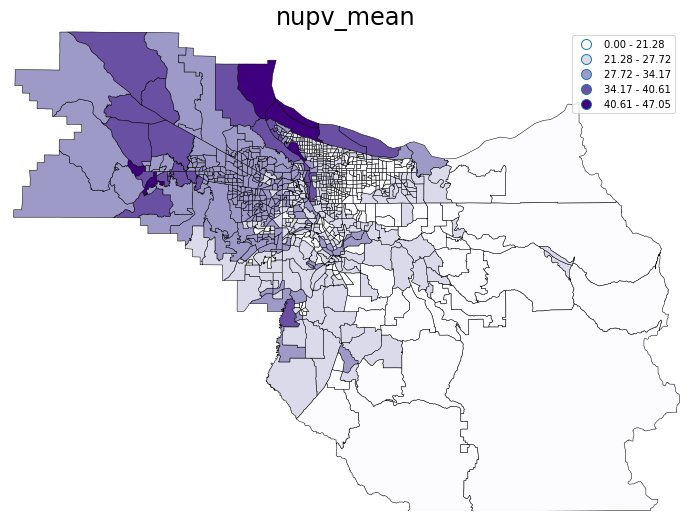

In [6]:
# Make a map showing distribution of df column, col2plot_y
#col2plot_y = 'casualties_avetotal'
#col2plot_y = 'buildingloss'
#col2plot_y = 'buildingloss_ratio'
col2plot_y = 'nupv_mean'

gplt.choropleth(gdf_merge,
                hue=gdf_merge[col2plot_y],  # Display data, passed as a Series
                projection=gplt.crs.AlbersEqualArea(),
                cmap='Purples',
                linewidth=0.5,
                edgecolor='black',
                k=5,
                legend=True,
                scheme='equal_interval',
                figsize=(12, 12)
)
plt.title("{}".format(col2plot_y), fontsize=24)

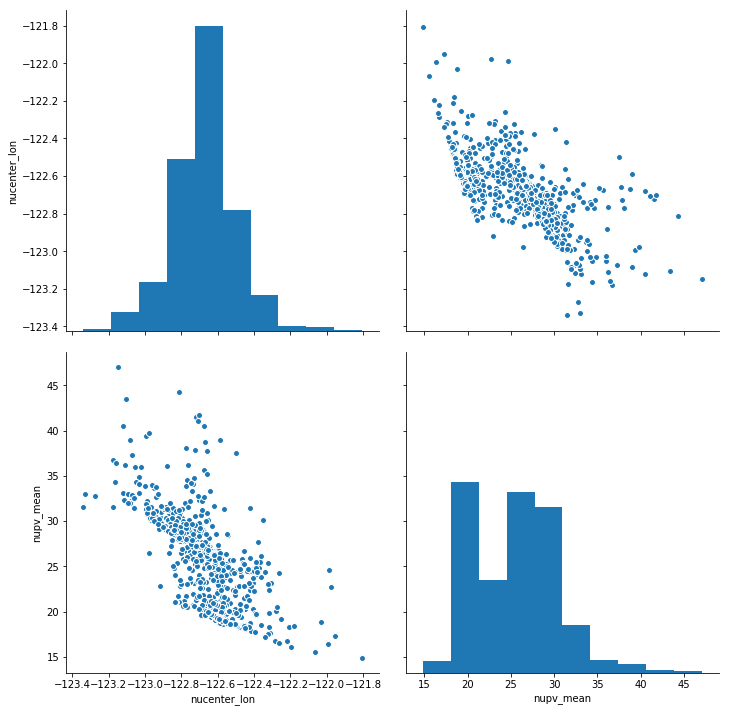

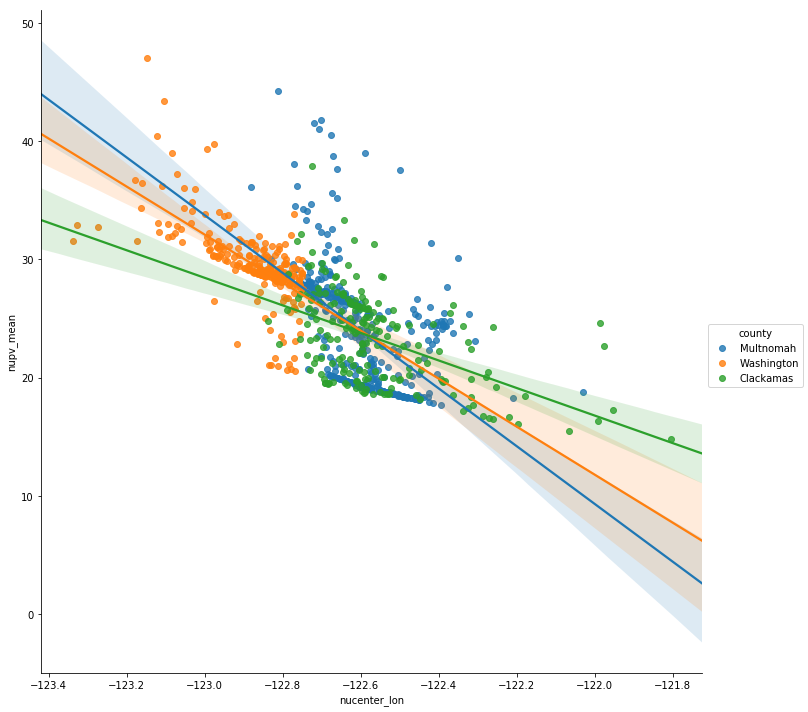

In [7]:
# Plot histograms and scatter plots of col2plot_x and col2plot_y
# then plot scatter plot of col2plot_y vs col2plot_x, with each
# marker color coded by county, and a linear fit to each county group
# For example, col2plot_y = 'nupv_mean' shows the average pgv for each
# neighborhood unit versus col2plot_x = 'nucenter_lon', the center longitude
# of each neighborhood unit (a proxy for distance from Cascadia fault)
# 
col2plot_x = 'nucenter_lon'
#col2plot_y = 'casualties_avetotal'
#col2plot_y = 'buildingloss'
#col2plot_y = 'buildingloss_ratio'
#col2plot_y = 'nupv_mean'
#col2plot_y = 'nucenter_pgv'
col2plot_y = 'nupv_mean'

sns.pairplot(gdf_merge, vars = [col2plot_x, col2plot_y], size=5)
sns.lmplot(col2plot_x, col2plot_y, hue="county",
           data=gdf_merge,
           fit_reg=True, 
           size=10)
#sns.lmplot(x=col2plot_x, y=col2plot_y, row=, col="time", data=tips, size=3)